
🌲 Random Forest Evaluation:
RMSE: 7.34
R² Score: -0.02
Epoch [1/200] - Avg Loss: 1.0048
Epoch [2/200] - Avg Loss: 0.9994
Epoch [3/200] - Avg Loss: 0.9956
Epoch [4/200] - Avg Loss: 0.9924
Epoch [5/200] - Avg Loss: 0.9898
Epoch [6/200] - Avg Loss: 0.9905
Epoch [7/200] - Avg Loss: 0.9856
Epoch [8/200] - Avg Loss: 0.9828
Epoch [9/200] - Avg Loss: 0.9806
Epoch [10/200] - Avg Loss: 0.9757
Epoch [11/200] - Avg Loss: 0.9761
Epoch [12/200] - Avg Loss: 0.9718
Epoch [13/200] - Avg Loss: 0.9688
Epoch [14/200] - Avg Loss: 0.9681
Epoch [15/200] - Avg Loss: 0.9612
Epoch [16/200] - Avg Loss: 0.9672
Epoch [17/200] - Avg Loss: 0.9622
Epoch [18/200] - Avg Loss: 0.9559
Epoch [19/200] - Avg Loss: 0.9556
Epoch [20/200] - Avg Loss: 0.9548
Epoch [21/200] - Avg Loss: 0.9476
Epoch [22/200] - Avg Loss: 0.9477
Epoch [23/200] - Avg Loss: 0.9406
Epoch [24/200] - Avg Loss: 0.9417
Epoch [25/200] - Avg Loss: 0.9409
Epoch [26/200] - Avg Loss: 0.9324
Epoch [27/200] - Avg Loss: 0.9321
Epoch [28/200] - Avg Loss: 0.9338
E

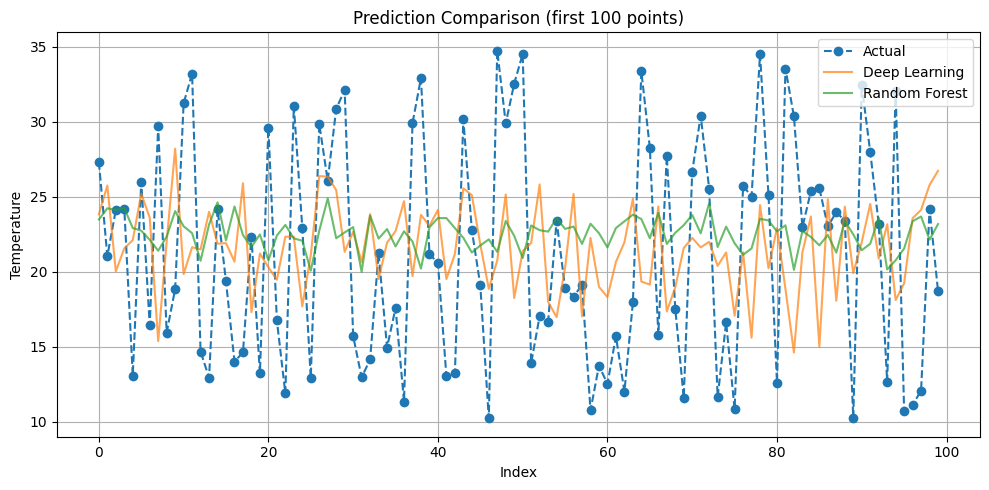

      Actual  Predicted
0  27.313866  23.824108
1  21.033037  25.743847
2  24.114928  20.023220
3  24.210476  21.561798
4  13.079491  22.108334
5  25.998026  25.194572
6  16.445542  23.603291
7  29.696236  15.378835
8  15.945181  22.008324
9  18.845476  28.199541


ValueError: 12 columns passed, passed data had 5 columns

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
import matplotlib.pyplot as plt
import pickle
import os

#1. Load and prepare data
train_df = pd.read_csv("../Data/train_data.csv")
test_df = pd.read_csv("../Data/test_data.csv")

#Feature Engineering
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
test_df['DateTime'] = pd.to_datetime(test_df['DateTime'])

# Hour, Month, Weekday
for df in [train_df, test_df]:
    df['Hour'] = df['DateTime'].dt.hour
    df['Month'] = df['DateTime'].dt.month
    df['Weekday'] = df['DateTime'].dt.weekday
    df['IsWeekend'] = (df['Weekday'] >= 5).astype(int)
    df['Season'] = df['Month'] % 12 // 3 + 1  # 1=Winter, 2=Spring, 3=Summer, 4=Fall
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Encode city — fit on train, transform both
city_encoder = LabelEncoder()
train_df['City_encoded'] = city_encoder.fit_transform(train_df['City'])
test_df['City_encoded'] = city_encoder.transform(test_df['City'])

#New features:
#['Humidity', 'Wind_Speed', 'Cloud_Cover', 'Pressure', 'Month', 'Weekday', 'IsWeekend', 'Season', 'Hour_sin', 'Hour_cos', 'City_encoded']

#Separate features and target
X_train = train_df.drop(columns=["City", "DateTime", "Rain", "Temperature"])
y_train = train_df[["Temperature"]]
X_test = test_df.drop(columns=["City", "DateTime", "Rain", "Temperature"])
y_test = test_df[["Temperature"]]

#2. Create two scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

#Scale features and targets separately
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

#3. Save scalers and features
os.makedirs("../Artifacts", exist_ok=True)
with open('../Artifacts/temp_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

with open('../Artifacts/temp_target_scaler.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)

with open('../Artifacts/temp_features.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

#Random Forest Regressor for comparison
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train.values.ravel())
rf_preds = rf.predict(X_test_scaled)

rf_r2 = r2_score(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print("\n🌲 Random Forest Evaluation:")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R² Score: {rf_r2:.2f}")

#4. Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#5. Define the model
class TemperatureRegressor(nn.Module):
    def __init__(self, input_dim):
        super(TemperatureRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

model = TemperatureRegressor(input_dim=X_train.shape[1])

#6. Train the model
def train_regression_model(model, train_dataset, val_dataset=None, epochs=200, batch_size=32, learning_rate=0.0005, patience=10):
    model.train()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)

        avg_loss = epoch_loss / len(train_dataset)

        print(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

#Calling the trian function
train_regression_model(model, train_dataset)

#7. Evaluate
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_tensor).numpy()
    predictions = target_scaler.inverse_transform(preds_scaled)

y_test_actual = y_test.values

#8. Metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)
max_err = max_error(y_test_actual, predictions)

print("\n Evaluation Report:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Max Error: {max_err:.2f}")

#9. Save model
torch.save(model.state_dict(), "../Artifacts/DeepLearn_model.pt")

#10. Scatter plot
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label="Actual", marker='o', linestyle='--')
plt.plot(predictions[:100], label="Deep Learning", alpha=0.7)
plt.plot(rf_preds[:100], label="Random Forest", alpha=0.7)
plt.legend()
plt.title("Prediction Comparison (first 100 points)")
plt.xlabel("Index")
plt.ylabel("Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()

#11. Export predictions
comparison = pd.DataFrame({
    "Actual": y_test_actual.flatten(),
    "Predicted": predictions.flatten()
})
comparison.to_csv("../Artifacts/predicted_vs_actual.csv", index=False)
print(comparison.head(10))

#12. Inference Function
def predict_temperature(input_string):
    with open("../Artifacts/temp_scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    with open("../Artifacts/temp_target_scaler.pkl", "rb") as f:
        target_scaler = pickle.load(f)
    with open("../Artifacts/temp_features.pkl", "rb") as f:
        feature_names = pickle.load(f)

    if isinstance(input_string, str):
        values = [float(x.strip()) for x in input_string.split(",")]
    elif isinstance(input_string, list):
        values = [float(x) for x in input_string]
    else:
        raise ValueError("Input must be a comma-separated string or a list of floats.")

    input_df = pd.DataFrame([values], columns=feature_names)
    input_scaled = scaler.transform(input_df)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)

    class TemperatureRegressor(nn.Module):
        def __init__(self, input_dim):
            super(TemperatureRegressor, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
        def forward(self, x):
            return self.model(x)

    model = TemperatureRegressor(input_dim=len(feature_names))
    model.load_state_dict(torch.load("../Artifacts/DeepLearn_model.pt"))
    model.eval()

    with torch.no_grad():
        scaled_pred = model(input_tensor).numpy()
        predicted_temp = target_scaler.inverse_transform(scaled_pred)

    return round(predicted_temp[0][0], 2)

#13. Test Inference
example_input = "89.59264065174611,7.335604391040214,50.50169383291316,1032.378758690279,1"
print(f"Predicted Temperature: {predict_temperature(example_input)} °C")
